<span style="font-size:3em;">Covid 19 Plots</span>

Note that you can manipulate the plots. You can...

* Single click on a label in the legend (e.g. "US") to remove that line from the plot (single click again to bring it back)
* Double click on a label in the legend (e.g. "US") to only show that line in the plot (double click again to bring back the others)
* Hover over a line to see its value at that point. You can change what you see. Clicking on the top row third icon from the right will show a single value for the line closest to your pointer [this is useful]. Clicking on the top row second icon from the right will show all values (the default). 

In [1]:
using Covid19    # My package under development
using DataFrames, DataFramesMeta
using Lazy: @>

# Get Covid19 data

Update to the latest data

In [52]:
updateJhuCSSE()

HEAD is now at 2c99a05 Merge pull request #2758 from CSSEGISandData/Update-6-25-Iowa
Updating 2c99a05..999a788
Fast-forward


From https://github.com/CSSEGISandData/COVID-19
   2c99a05..999a788  master     -> origin/master


 README.md                                          |    2 +
 csse_covid_19_data/README.md                       |    1 +
 .../csse_covid_19_daily_reports/06-25-2020.csv     | 3782 ++++++++++++
 .../csse_covid_19_daily_reports_us/06-25-2020.csv  |   59 +
 .../csse_covid_19_time_series/Errata.csv           |    4 +
 .../time_series_covid19_confirmed_US.csv           | 6524 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |  534 +-
 .../time_series_covid19_deaths_US.csv              | 6524 ++++++++++----------
 .../time_series_covid19_deaths_global.csv          |  534 +-
 .../time_series_covid19_recovered_global.csv       |  508 +-
 10 files changed, 11160 insertions(+), 7312 deletions(-)
 create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/06-25-2020.csv
 create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports_us/06-25-2020.csv


Process(`git -C /Users/lyon/Development/Julia/Covid19/Covid19/src/../jhu_csse_covid19 pull`, ProcessExited(0))

Get the confirmed global cases dataset

In [53]:
confirmedCases = getCovid19Data(ConfirmedCases, CountryLevel, 30);  # Start when at least 30 cases

What's the last date we have?

In [54]:
nrow(confirmedCases)

16092

In [55]:
maximum(confirmedCases.Date)

2020-06-25

# US cases

In [56]:
confirmedCasesUS = @where(confirmedCases, :Country_Region .== "US", :daysSince .>= 3);

In [57]:
using Plots          # Note that currently we need RecipesPipeline#master so that we get correct group sorting (pull request #59)
using StatsPlots
using Format
plotlyjs(size=(700,400))

# Format numbers with commas
fc(x) = format(x, commas=true, precision=0)

fc (generic function with 1 method)

Total # of cases (left is linear, right is log)

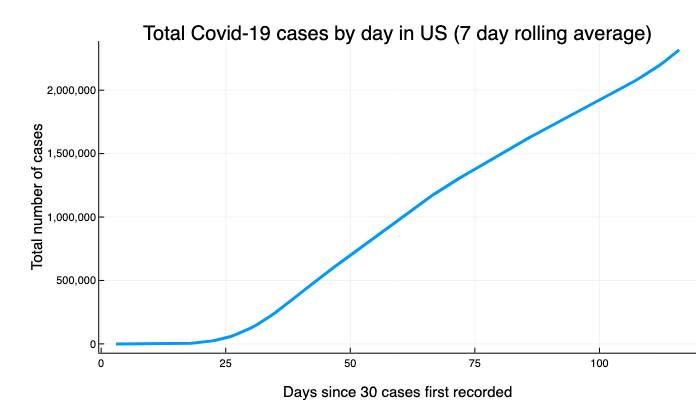

In [58]:
p = @df confirmedCasesUS plot(:daysSince, :Value_rolling7, xaxis="Days since 30 cases first recorded",
                            yaxis="Total number of cases", yformatter=fc,
                            title="Total Covid-19 cases by day in US (7 day rolling average)",
                            label=nothing, linewidth=3)

In [59]:
savefig(p, "bla.html")

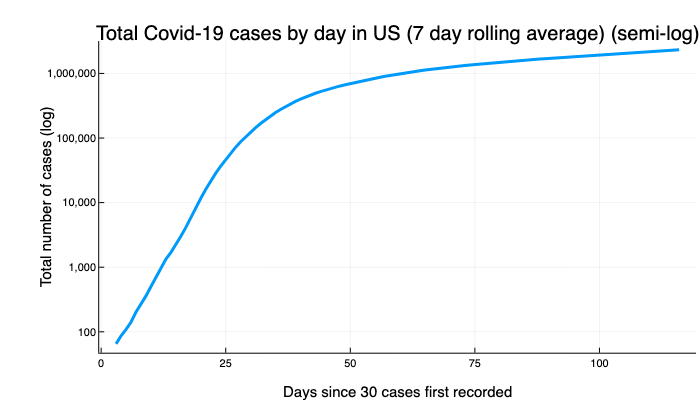

In [60]:
@df confirmedCasesUS plot(:daysSince, :Value_rolling7, xaxis="Days since 30 cases first recorded",
                            yaxis="Total number of cases (log)", yformatter=fc, 
                            yscale=:log10,
                            title="Total Covid-19 cases by day in US (7 day rolling average) (semi-log)",
                            label=nothing, linewidth=3)

Number of new cases

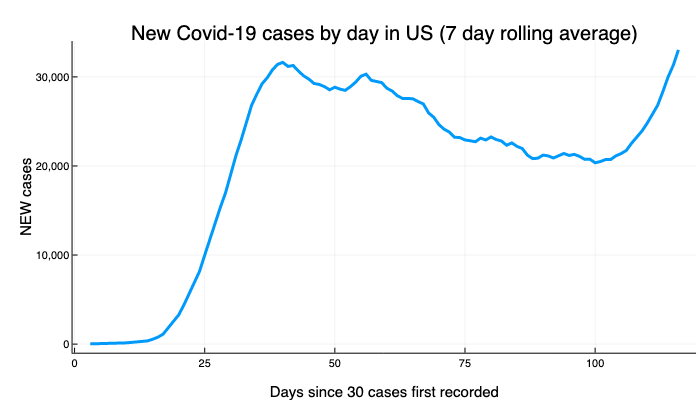

In [61]:
@df confirmedCasesUS plot(:daysSince, :Value_new_rolling7, xaxis="Days since 30 cases first recorded",
                            yaxis="NEW cases", yformatter=fc,
                            title="New Covid-19 cases by day in US (7 day rolling average)",
                            label=nothing, linewidth=3)

## Compare rolling average to raw data

Let's try to reproduce a New York Times plot - comparing a rolling average to the actual values

A function to do the actual with 7 day rolling average

In [62]:
function plotActualAnd7DayAvg(df, value::Symbol, valueRolling7::Symbol, ylab, ylog=false, legend=:topright)
    @df df plot(:Date, df[!, value], linewidth=3, yformatter=fc, yminorticks=true, xrotation=45, 
                              label=ylab, yscale= ylog ? :log10 : :identity, legend=legend,
                              yaxis=ylab)
    @df df plot!(:Date, df[!, valueRolling7], linewidth=3, label="7 day rolling average")
end

plotActualAnd7DayAvg (generic function with 3 methods)

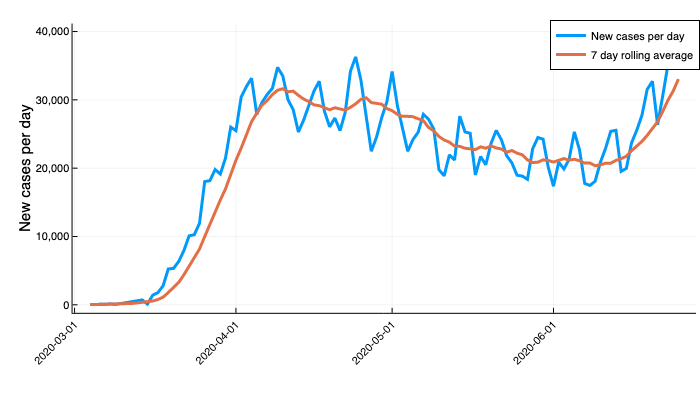

In [63]:
plotActualAnd7DayAvg(confirmedCasesUS, :Value_new, :Value_new_rolling7, "New cases per day")

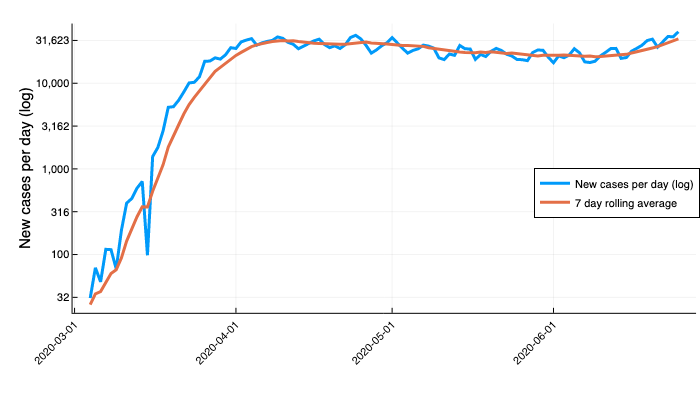

In [64]:
plotActualAnd7DayAvg(confirmedCasesUS, :Value_new, :Value_new_rolling7, "New cases per day (log)", true, :right)

How many cases are there?

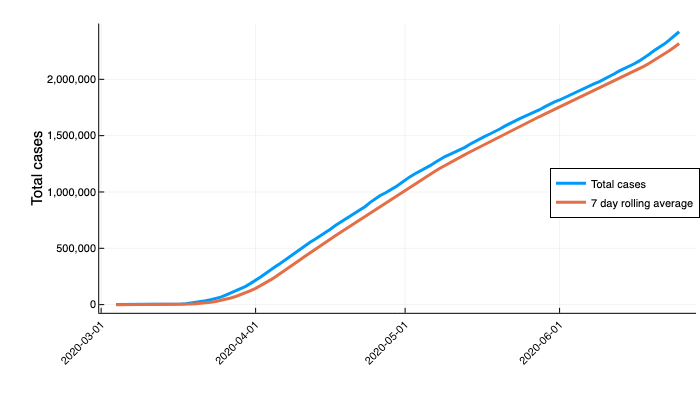

In [65]:
plotActualAnd7DayAvg(confirmedCasesUS, :Value, :Value_rolling7, "Total cases", false, :right)

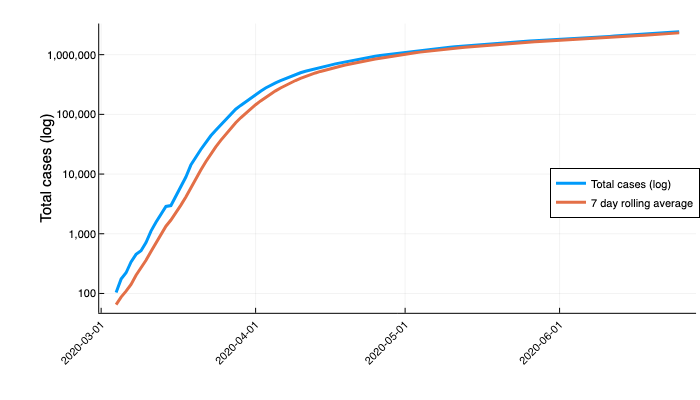

In [66]:
plotActualAnd7DayAvg(confirmedCasesUS, :Value, :Value_rolling7, 
                     "Total cases (log)", true, :right)

## Compare US to EU

The following replicates a plot shown on CNN comparing US and EU new cases
See https://sanjuanislander.com/news-articles/31295/a-sobering-chart-eu-vs-usa-statistics-of-confirmed-covid-cases
The countries aren't all of the ones in the EU, but seem to be the largest contributors. 

In [67]:
eu = ["France", "Germany", "Italy", "United Kingdom", "Spain", "Switzerland", "Austria", "Portugal"]
confirmedCasesEU = @where(confirmedCases, in.(:Country_Region, [eu]), :daysSince .>= 3)
confirmedCasesEU = combine(groupby(confirmedCasesEU, :Date), [:Value_new_rolling7] => sum => :Value_new_rolling7);

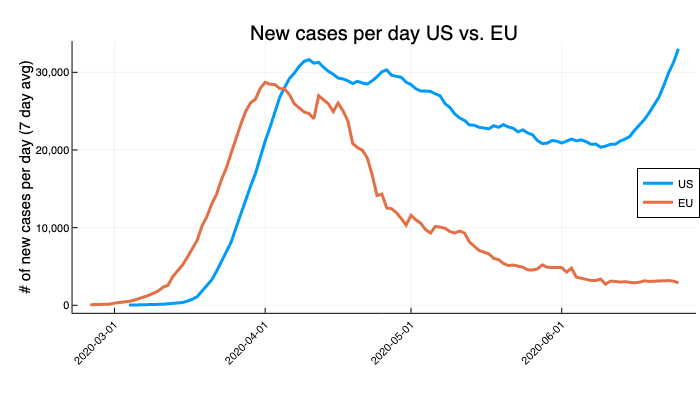

In [68]:
@df confirmedCasesUS plot(:Date, :Value_new_rolling7, label="US", lw=3, legend=:right)
@df confirmedCasesEU plot!(:Date, :Value_new_rolling7, yformatter=fc, xrotation=45, label="EU", lw=3)
plot!(title="New cases per day US vs. EU", ylab="# of new cases per day (7 day avg)")

# Top global cases

Find the countries with the most cases.

In [69]:
function topCountries(df::DataFrame, n::Int)
    tc = @> begin    # Construct a pipeline
        df   
        sort( [:Date, :Value], rev=(true, true))
        first(n)                 # Get the n largest
        getindex(:, :Country_Region)   # Pull out the country/region name
    end
    String.(tc)
end

topCountries (generic function with 1 method)

In [70]:
categorical!(confirmedCases, :Country_Region);

In [71]:
topCountriesCases = topCountries(confirmedCases, 10);
push!(topCountriesCases, "Sweden");  # Let's include Sweden to see how they compare

In [72]:
confirmedCasesTop = @where(confirmedCases, in.(:Country_Region, [topCountriesCases]), :Value_new .> 0);

In [73]:
levels!(confirmedCasesTop.Country_Region, topCountriesCases)
droplevels!(confirmedCasesTop.Country_Region);
ordered!(confirmedCasesTop.Country_Region, true);

In [74]:
levels(confirmedCasesTop.Country_Region)

11-element Array{String,1}:
 "US"
 "Brazil"
 "Russia"
 "India"
 "United Kingdom"
 "Peru"
 "Chile"
 "Spain"
 "Italy"
 "Iran"
 "Sweden"

Plot the cases

In [75]:
lw = fill(2, (1,length(topCountriesCases))); lw[1] = 5;

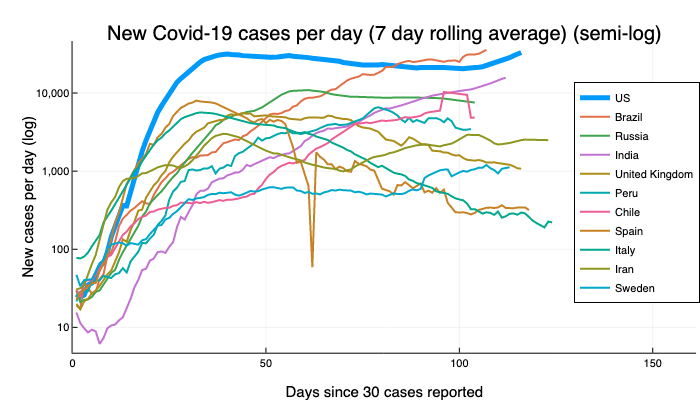

In [76]:
@df confirmedCasesTop plot(:daysSince, :Value_new_rolling7, group=:Country_Region,
                           yscale=:log10, yformatter=fc, yminorticks=true, legend=:right, lw=lw,
                           xaxis="Days since 30 cases reported", yaxis="New cases per day (log)",
                           xlimit=(0, maximum(:daysSince)*1.3),
                           title="New Covid-19 cases per day (7 day rolling average) (semi-log)")

Plot trajectory like https://aatishb.com/covidtrends/

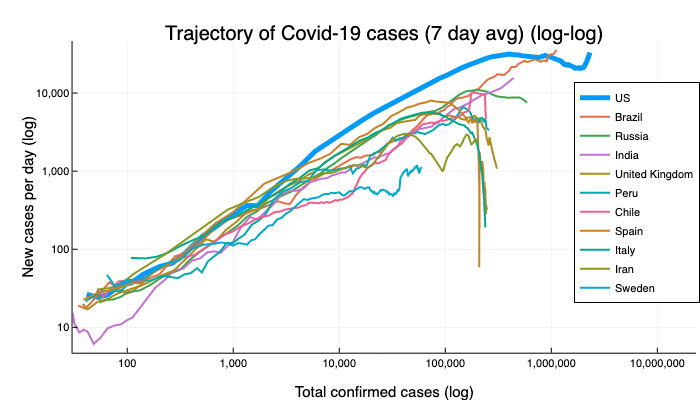

In [78]:
@df confirmedCasesTop plot(:Value_rolling7, :Value_new_rolling7, group=:Country_Region,
                      yscale=:log10, xscale=:log10, lw=lw, legend=:right,
                      xformatter=fc, yformatter=fc, xminorticks=true, yminorticks=true,
                      xlimit=(minimum(:Value_rolling7), maximum(:Value_rolling7)*10),
                      xlab="Total confirmed cases (log)", ylab="New cases per day (log)",
                      title="Trajectory of Covid-19 cases (7 day avg) (log-log)")

# Covid 19 deaths

In [79]:
deaths = getCovid19Data(Deaths, CountryLevel, 3);

## US Deaths

In [80]:
deathsUS = @where(deaths, :Country_Region.=="US" );

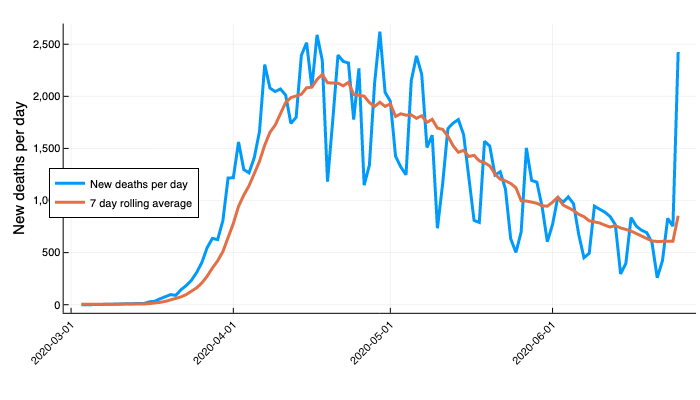

In [84]:
plotActualAnd7DayAvg(deathsUS, :Value_new, :Value_new_rolling7, "New deaths per day", false, :left)

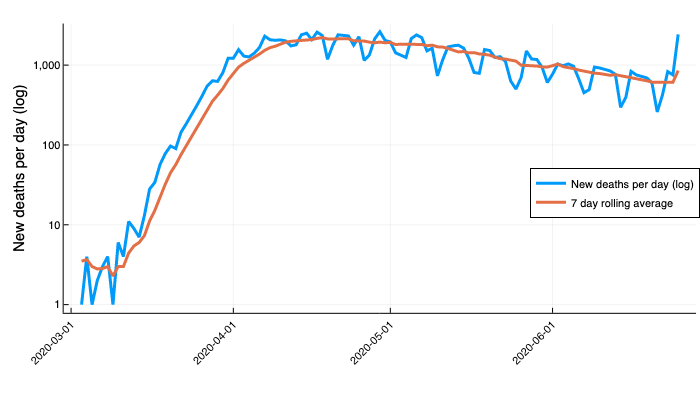

In [82]:
plotActualAnd7DayAvg(deathsUS, :Value_new, :Value_new_rolling7, "New deaths per day (log)", true, :right)

How may deaths are we up to?

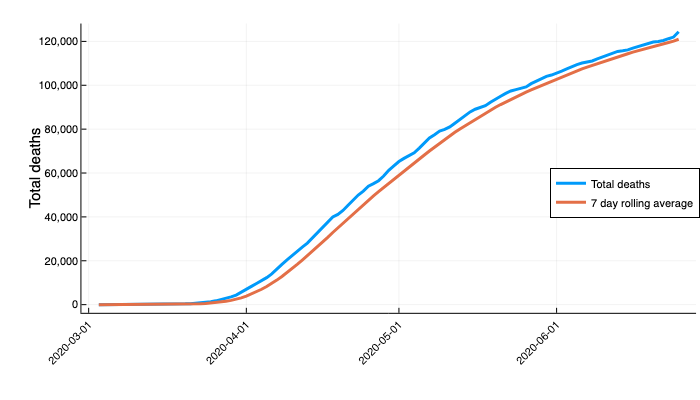

In [85]:
plotActualAnd7DayAvg(deathsUS, :Value, :Value_rolling7, "Total deaths", false, :right)

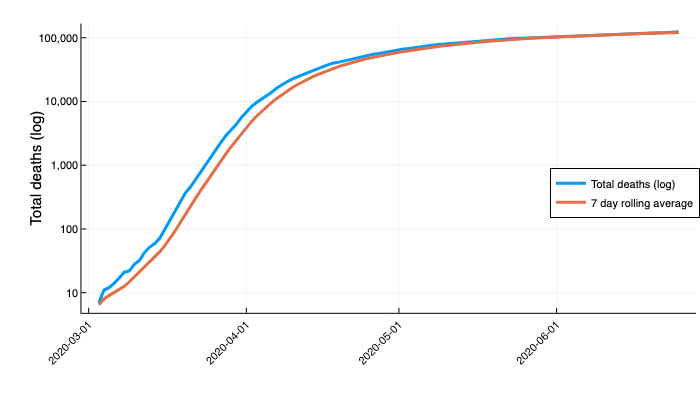

In [86]:
plotActualAnd7DayAvg(deathsUS, :Value, :Value_rolling7, "Total deaths (log)", true, :right)

## Top Countries for Deaths

In [87]:
categorical!(deaths, :Country_Region);

In [88]:
topCountriesDeaths = topCountries(deaths, 10);
push!(topCountriesDeaths, "Sweden")

deathsTop = @where(deaths, in.(:Country_Region, [topCountriesDeaths]), :Value_new .> 0, :Value_new_rolling7 .> 0);

In [89]:
levels!(deathsTop.Country_Region, topCountriesDeaths)
droplevels!(deathsTop.Country_Region);
ordered!(deathsTop.Country_Region, true);

In [90]:
levels(deathsTop.Country_Region)

11-element Array{String,1}:
 "US"
 "Brazil"
 "United Kingdom"
 "Italy"
 "France"
 "Spain"
 "Mexico"
 "India"
 "Iran"
 "Belgium"
 "Sweden"

In [91]:
lw = fill(2, (1,length(topCountriesDeaths)));
lw[1] = 5;

Since we're doing a long plot, we need positive values...

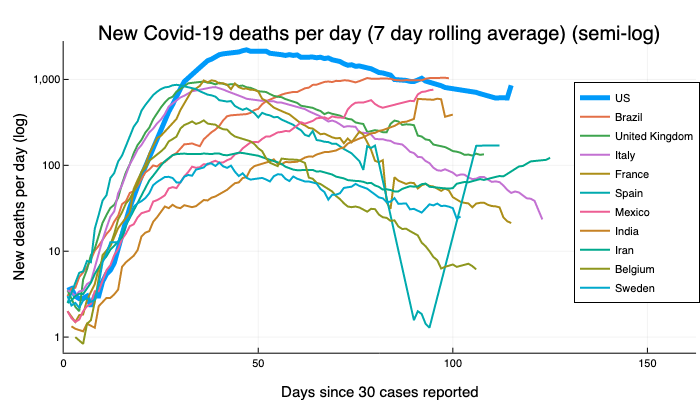

In [92]:
@df deathsTop plot(:daysSince, :Value_new_rolling7, group=:Country_Region,
                           yformatter=fc, yminorticks=true, legend=:right, lw=lw, yscale=:log10,
                           xlimit=(0, maximum(:daysSince)*1.3), 
                           xaxis="Days since 30 cases reported", yaxis="New deaths per day (log)",
                           title="New Covid-19 deaths per day (7 day rolling average) (semi-log)")

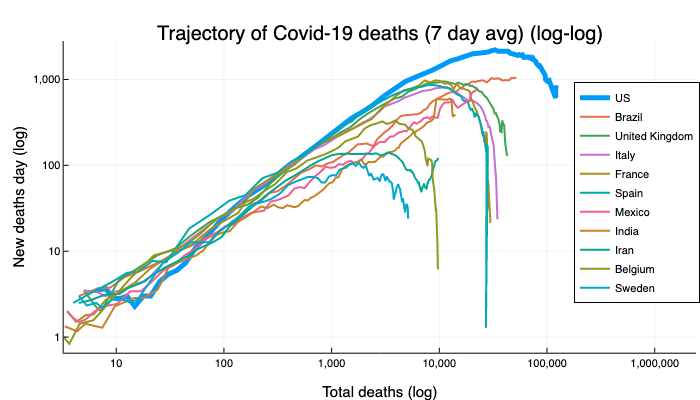

In [93]:
@df deathsTop plot(:Value_rolling7, :Value_new_rolling7, group=:Country_Region,
                      yscale=:log10, xscale=:log10, lw=lw, legend=:right,
                      xformatter=fc, yformatter=fc, xminorticks=true, yminorticks=true,
                      xlimit=(minimum(:Value_rolling7), maximum(:Value_rolling7)*20),
                      xlab="Total deaths (log)", ylab="New deaths day (log)",
                      title="Trajectory of Covid-19 deaths (7 day avg) (log-log)")

# Plots per capita (per million people)
Comparing the US to other countries in the plots above may be unfair as population may have an influence on number of cases and such (larger countries have more people who can get the virus). Make plots by dividing by the population of the country... per capita plots.

Get the country population data

In [94]:
using CSV

In [95]:
popDataPath = joinpath(@__DIR__, "..", "data", "country_populations.csv")
popData = CSV.read(popDataPath, header=5, skipto=6, select=["Country Name", "2018"]) # header is line 5, data starts on line 6
rename!(x->Symbol(replace(string(x), " " => "")), popData)
rename!(popData, Symbol("2018") => :pop)
popData = @transform(popData, country=replace(:CountryName, "United States" => "US", "Iran, Islamic Rep." => "Iran"));

## Cases per capita

Join this with the top confirmed cases dataframe

In [96]:
fcpc(x) = format(x, commas=true)

fcpc (generic function with 1 method)

In [97]:
confirmedCasesTopPerCap = innerjoin(confirmedCasesTop, popData, on=:Country_Region=>:country)
confirmedCasesTopPerCap = @transform(confirmedCasesTopPerCap,
                            Value_rolling7_perCap = :Value_rolling7 ./ :pop .* 1_000_000,
                            Value_new_rolling7_perCap = :Value_new_rolling7 ./ :pop .* 1_000_000);

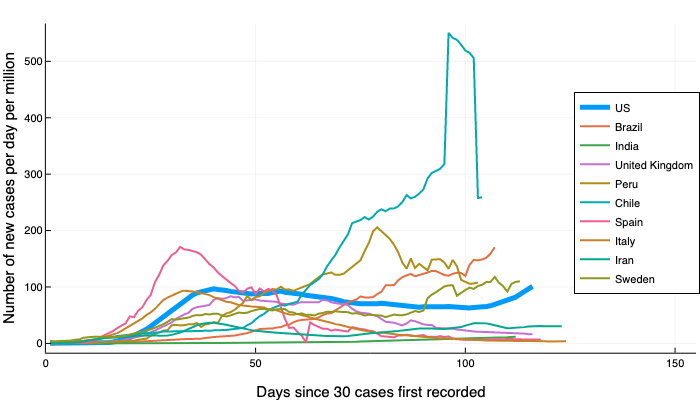

In [98]:
@df confirmedCasesTopPerCap plot(:daysSince, :Value_new_rolling7_perCap, group=:Country_Region,
                                 xaxis="Days since 30 cases first recorded", yaxis="Number of new cases per day per million",
                                 xlimit=(0, maximum(:daysSince)*1.25), legend=:right, lw=lw)

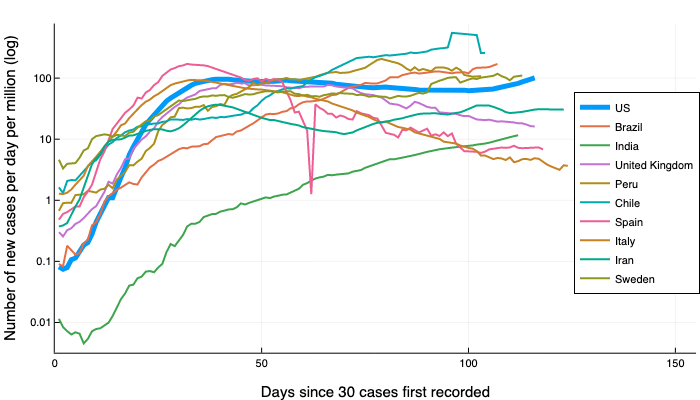

In [99]:
@df confirmedCasesTopPerCap plot(:daysSince, :Value_new_rolling7_perCap, group=:Country_Region,
                                 xaxis="Days since 30 cases first recorded", yaxis="Number of new cases per day per million (log)", yscale=:log10,
                                 xlimit=(0, maximum(:daysSince)*1.25), legend=:right, lw=lw, yformatter=fcpc, yminorticks=true)

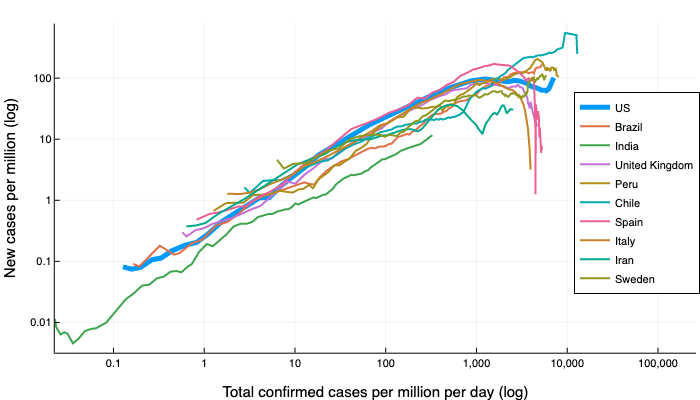

In [100]:
@df confirmedCasesTopPerCap plot(:Value_rolling7_perCap, :Value_new_rolling7_perCap, group=:Country_Region,
                                 xscale=:log10, yscale=:log10,
                                 xformatter=fcpc, yformatter=fcpc, legend=:right, lw=lw,
                                 xlimit=(minimum(:Value_rolling7_perCap), maximum(:Value_rolling7_perCap)*20),
                                 xaxis="Total confirmed cases per million per day (log)", 
                                 yaxis="New cases per million (log)")

## Deaths per capita

In [101]:
deathsTopPerCap = innerjoin(deathsTop, popData, on=:Country_Region => :country)
deathsTopPerCap = @transform(deathsTopPerCap,
                             Value_rolling7_perCap = :Value_rolling7 ./ :pop .* 1_000_000,
                             Value_new_rolling7_perCap = :Value_new_rolling7 ./ :pop .* 1_000_000);

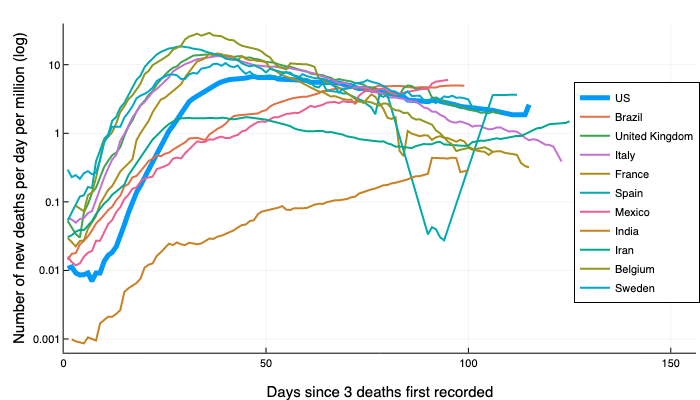

In [102]:
@df deathsTopPerCap plot(:daysSince, :Value_new_rolling7_perCap, group=:Country_Region,
                                 xaxis="Days since 3 deaths first recorded", yaxis="Number of new deaths per day per million (log)", yscale=:log10,
                                 xlimit=(0, maximum(:daysSince)*1.25), legend=:right, lw=lw, yformatter=fcpc, yminorticks=true)

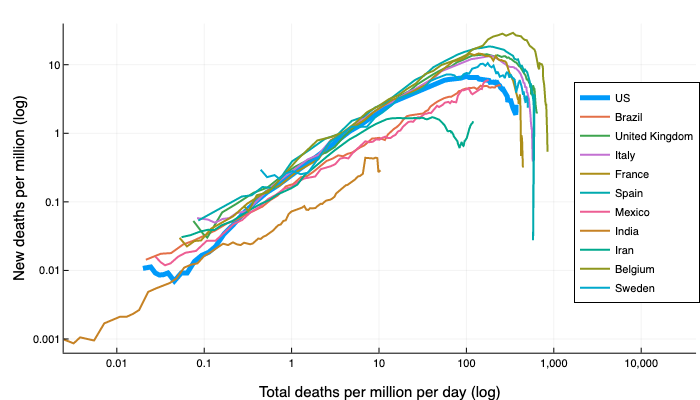

In [103]:
@df deathsTopPerCap plot(:Value_rolling7_perCap, :Value_new_rolling7_perCap, group=:Country_Region,
                                 xscale=:log10, yscale=:log10,
                                 xformatter=fcpc, yformatter=fcpc, legend=:right, lw=lw,
                                 xlimit=(minimum(:Value_rolling7_perCap), maximum(:Value_rolling7_perCap)*50),
                                 xaxis="Total deaths per million per day (log)", 
                                 yaxis="New deaths per million (log)")